In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Machine Learning & Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# NLP & GenAI
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('display.max_colwidth', 150)

# Select Device (GPU if available, else CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
import os
# STRICTLY set this to 1 to prevent kernel crashes on clustering
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [3]:
# Load Data
file_path = '../dataset/Tweets.csv'

df = pd.read_csv(file_path)

print(f"Dataset Successfully Loaded: {df.shape[0]} rows.")

# Cleaning & Preprocessing 
def clean_tweet(text):
    if not isinstance(text, str): return ""
    # 1. Change to lowercase
    text = text.lower()
    # 2. Remove mentions (for e.g, @United)
    text = " ".join([word for word in text.split() if not word.startswith('@')])
    # 3. Remove whitespace
    return text.strip()

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_tweet)

# Filter out empty tweets after cleaning
df = df[df['cleaned_text'].str.len() > 5].reset_index(drop=True)

df_sample = df.copy()

print(f"Data Cleaned & Ready. Working with {len(df_sample)} tweets.")
display(df_sample[['airline_sentiment', 'cleaned_text']].head())

Dataset Successfully Loaded: 14640 rows.
Data Cleaned & Ready. Working with 14601 tweets.


,airline_sentiment,cleaned_text
0,neutral,what said.
1,positive,plus you've added commercials to the experience... tacky.
2,neutral,i didn't today... must mean i need to take another trip!
3,negative,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,and it's a really big bad thing about it


In [4]:
print("Loading SBERT model...")
# 'all-MiniLM-L6-v2' is optimized for speed and performance
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

print("Generating embeddings for all tweets...")
embeddings = embedder.encode(df_sample['cleaned_text'].tolist(), show_progress_bar=True)

print(f"Embedding Shape: {embeddings.shape}") 

Loading SBERT model...
Generating embeddings for all tweets...


Batches:   0%|          | 0/457 [00:00<?, ?it/s]

Embedding Shape: (14601, 384)


In [5]:
# Reduce dimensions to preserve 95% variance
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
embeddings_pca = pca.fit_transform(embeddings)

print(f"Original Dimensions: {embeddings.shape[1]}")
print(f"Reduced Dimensions: {embeddings_pca.shape[1]}")
print(f"Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.2f}")

Original Dimensions: 384
Reduced Dimensions: 246
Explained Variance Ratio: 0.95


k=2: silhouette=0.0484, db=4.4492, inertia=10762.91
k=3: silhouette=0.0451, db=4.9211, inertia=10558.83
k=4: silhouette=0.0168, db=5.1764, inertia=10400.24
k=5: silhouette=0.0201, db=4.8664, inertia=10262.73
k=6: silhouette=0.0223, db=4.8044, inertia=10150.67
k=7: silhouette=0.0217, db=4.6056, inertia=10050.93
k=8: silhouette=0.0228, db=4.5445, inertia=9963.58
k=9: silhouette=0.0229, db=4.4077, inertia=9889.02
k=10: silhouette=0.0216, db=4.2169, inertia=9805.45
k=11: silhouette=0.0222, db=4.1124, inertia=9735.58
k=12: silhouette=0.0231, db=4.0649, inertia=9671.95
k=13: silhouette=0.0228, db=4.1642, inertia=9621.07
k=14: silhouette=0.0235, db=4.1907, inertia=9574.70
k=15: silhouette=0.0243, db=4.0723, inertia=9532.18
k=16: silhouette=0.0231, db=4.1568, inertia=9494.93
k=17: silhouette=0.0228, db=4.0632, inertia=9453.08
k=18: silhouette=0.0240, db=4.0526, inertia=9420.12
k=19: silhouette=0.0235, db=4.1042, inertia=9379.95
k=20: silhouette=0.0232, db=4.0173, inertia=9350.48
k=21: silhouet

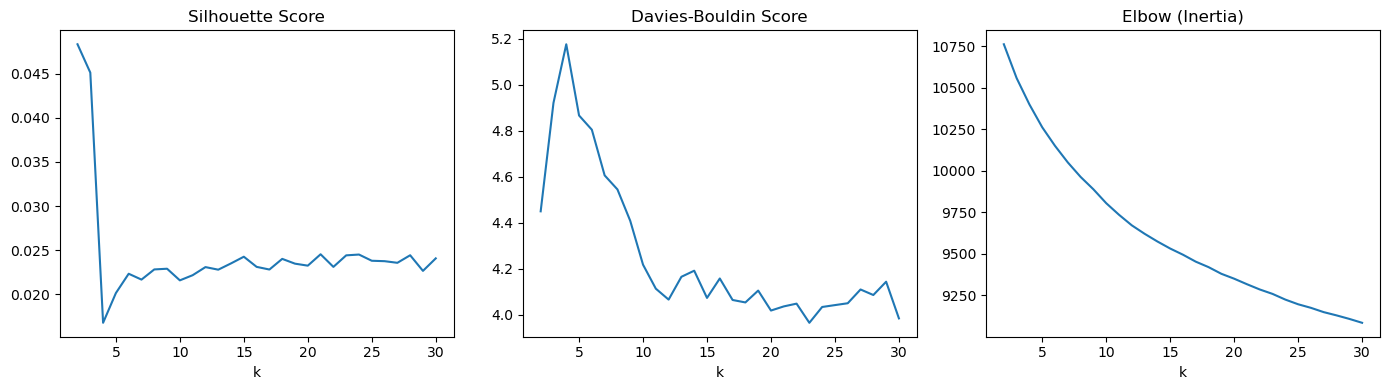

Best k by Silhouette Score: 2
Best k by Davies–Bouldin Score: 23


In [15]:
# Determining best K value for K Means
results = []
for k in range(2, 31):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(embeddings_pca)

    sil = silhouette_score(embeddings_pca, labels)
    db = davies_bouldin_score(embeddings_pca, labels)
    inertia = km.inertia_

    results.append((k, sil, db, inertia))

    print(f"k={k}: silhouette={sil:.4f}, db={db:.4f}, inertia={inertia:.2f}")

ks = [r[0] for r in results]
sil_scores = [r[1] for r in results]
db_scores = [r[2] for r in results]
inertias = [r[3] for r in results]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(ks, sil_scores)
plt.title("Silhouette Score")
plt.xlabel("k")

plt.subplot(1,3,2)
plt.plot(ks, db_scores)
plt.title("Davies-Bouldin Score")
plt.xlabel("k")

plt.subplot(1,3,3)
plt.plot(ks, inertias)
plt.title("Elbow (Inertia)")
plt.xlabel("k")

plt.tight_layout()
plt.show()

# Max silhouette
best_sil_k = ks[np.argmax(sil_scores)]

# Min DB index
best_db_k = ks[np.argmin(db_scores)]

print(f"Best k by Silhouette Score: {best_sil_k}")
print(f"Best k by Davies–Bouldin Score: {best_db_k}")


In [28]:
# This value was determined after the analysis above
num_clusters = 17

print(f"Running KMeans with {num_clusters} clusters...")
kmeans = KMeans(n_clusters=num_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings_pca)

# Add labels to DataFrame
df_sample['kmeans_cluster'] = kmeans_labels

# Evaluation Metrics
sil_score = silhouette_score(embeddings_pca, kmeans_labels)
db_score = davies_bouldin_score(embeddings_pca, kmeans_labels)

print("KMeans Results")
# The higher the silhoutte score, the better, while opposite is true for Davies-Boudin score.
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Score: {db_score:.4f}")

# Show distribution of clusters
print("\nCluster Distribution:")
print(df_sample['kmeans_cluster'].value_counts().sort_index())

Running KMeans with 17 clusters...
KMeans Results
Silhouette Score: 0.0228
Davies-Bouldin Score: 4.0632

Cluster Distribution:
kmeans_cluster
0      879
1     1155
2     1045
3      848
4     1158
5      218
6      704
7      935
8      817
9     1164
10     148
11     463
12     930
13     730
14     745
15    1092
16    1570
Name: count, dtype: int64


/var/folders/96/qws71v05345fdnzph2283lrc0000gn/T/ipykernel_21865/812487811.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


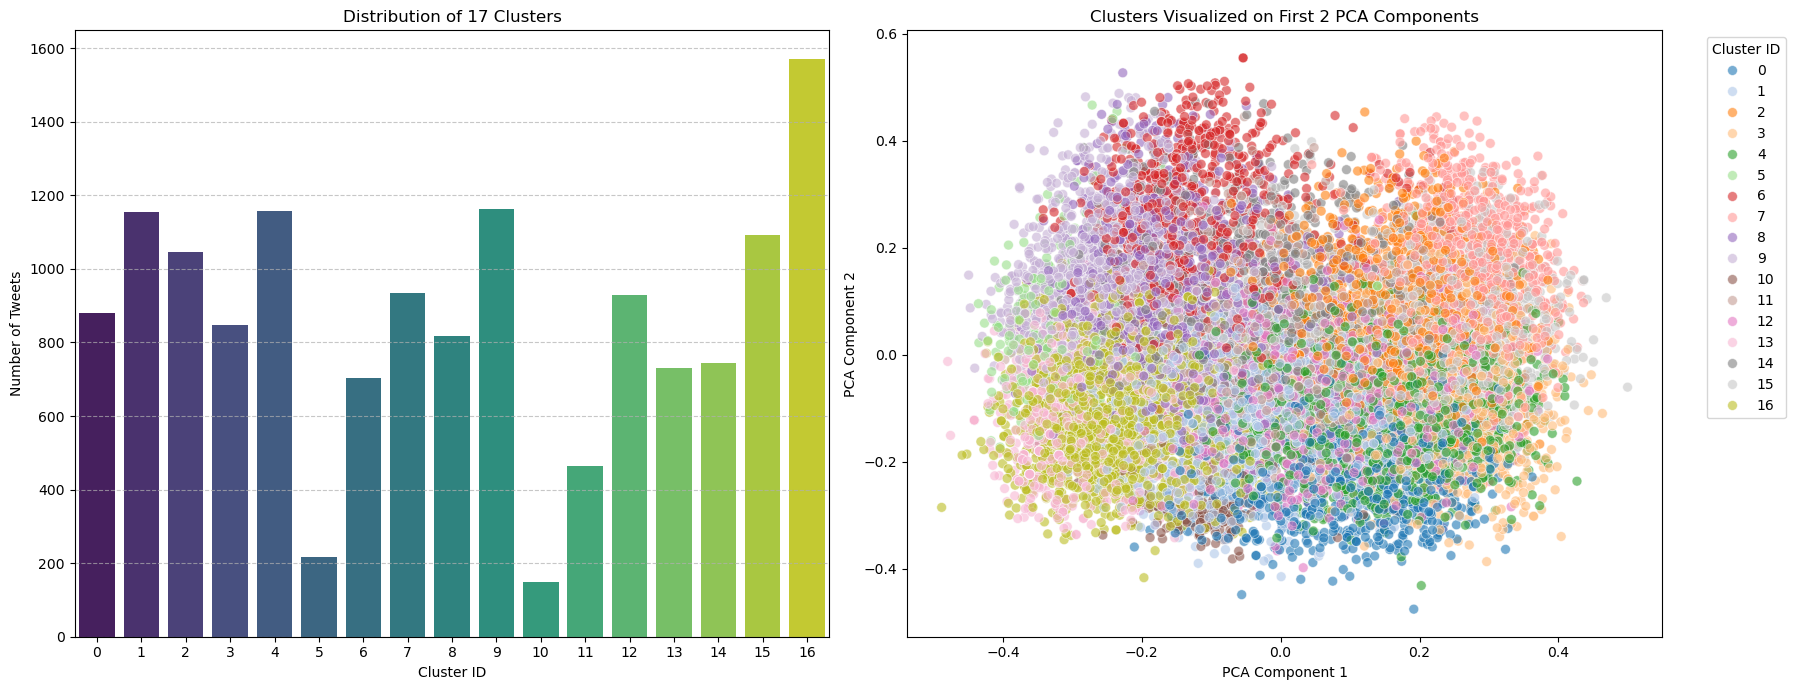

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size
plt.figure(figsize=(18, 7))

# --- Plot 1: Cluster Distribution (Bar Chart) ---
plt.subplot(1, 2, 1)
# Calculate counts for sorted display
counts = df_sample['kmeans_cluster'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.title(f'Distribution of {num_clusters} Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Plot 2: Clusters on PCA Components (Scatter Plot) ---
# We take the first two dimensions of the PCA embeddings for visualization
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=embeddings_pca[:, 0], 
    y=embeddings_pca[:, 1], 
    hue=kmeans_labels, 
    palette='tab20',  # 'tab20' has enough distinct colors for 17 clusters
    s=50, 
    alpha=0.6,
    legend='full'
)
plt.title('Clusters Visualized on First 2 PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster ID', ncol=1)

plt.tight_layout()
plt.show()

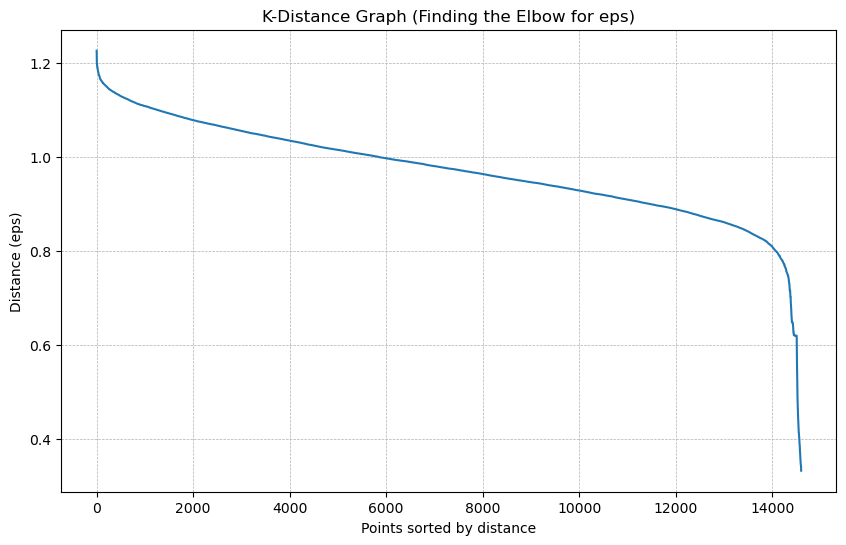

In [41]:
# Figuring out DBSCAN optimal eps value

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np


k = 50 
nbrs = NearestNeighbors(n_neighbors=k).fit(embeddings_pca)
distances, indices = nbrs.kneighbors(embeddings_pca)

# We focus on the distance to the k-th nearest neighbor
distance_desc = sorted(distances[:, k-1], reverse=True)

plt.figure(figsize=(10, 6))
plt.plot(distance_desc)
plt.title('K-Distance Graph (Finding the Elbow for eps)')
plt.ylabel('Distance (eps)')
plt.xlabel('Points sorted by distance')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [42]:
# DBSCAN Configuration 
EPS_VALUE = 0.8
MIN_SAMPLES = 20

print(f"Running DBSCAN (eps={EPS_VALUE}, min_samples={MIN_SAMPLES})...")
dbscan = DBSCAN(eps=EPS_VALUE, min_samples=MIN_SAMPLES)
dbscan_labels = dbscan.fit_predict(embeddings_pca)

# Add to dataframe
df_sample['dbscan_cluster'] = dbscan_labels

# Count clusters (excluding noise -1)
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
noise_percent = (n_noise / len(df_sample)) * 100

print("DBSCAN Results")
print(f"Estimated number of clusters: {n_clusters_db}")
print(f"Noise points (Cluster -1): {n_noise} ({noise_percent:.1f}%)")

Running DBSCAN (eps=0.8, min_samples=20)...
DBSCAN Results
Estimated number of clusters: 6
Noise points (Cluster -1): 11105 (76.1%)
